In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
from PIL import Image
from matplotlib.ticker import FormatStrFormatter
import json
import pandas as pd

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'
train_transforms = transforms.Compose([transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.ColorJitter(brightness=0.8,contrast=0.1, saturation=0.01, hue=0.001),
                                       transforms.RandomResizedCrop(size=224, scale=(0.5, 2), ratio=(1, 1)),
                                       #did not want to resize too much since some resizing leaves black borders
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                           [0.229,0.224,0.225])])

test_transforms = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485,0.456,0.406],
                                                          [0.229,0.224,0.225])])

vldtn_transforms = transforms.Compose([transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485,0.456,0.406],
                                                            [0.229,0.224,0.225])])

train_data = datasets.ImageFolder(train_dir, transform = train_transforms)
test_data = datasets.ImageFolder(test_dir, transform = test_transforms)
vldtn_data = datasets.ImageFolder(valid_dir, transform = vldtn_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size = 64)
vldtnloader = torch.utils.data.DataLoader(vldtn_data, batch_size = 64)

In [3]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

In [4]:
model = models.densenet161(pretrained = True)

C:\AnaconML\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [ ]:
#freeze feature parameters, we only want to train classifier, not the whole network
for p in model.parameters():
    p.requires_grad = False
    
p_drop= 0.5 
in_ft = model.classifier.in_features
hidden_n = in_ft

classifierHL1 = nn.Sequential(OrderedDict([("fc1", nn.Linear(in_ft, hidden_n)),
                                           ("relu1",nn.ReLU()),
                                           ("dropout1", nn.Dropout(p_drop)),
                                           ("bn1", nn.BatchNorm1d(hidden_n)),#added BN for faster learning
                                           ("out_layer", nn.Linear(hidden_n, 102)),
                                           ("softmax", nn.LogSoftmax(dim=1))]))
model.classifier = classifierHL1

In [ ]:
#Train and do validation on the test set
from workspace_utils import keep_awake
model.to('cuda')
epochs = 3
learn_rate = 0.000001
print_every = 40
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = learn_rate, weight_decay=0.01)

model.train()
for q in keep_awake(range(1)):
    steps = 0
    for e in range(epochs):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader):
            steps += 1
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            optimizer.zero_grad()
            # Forward and backward passes
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if steps % print_every == 0:
                model.eval()
                with torch.no_grad():
                    vldtn_loss = 0
                    correct = 0
                    total = 0
                    for data in vldtnloader:
                        images, vlabels = data
                        images, vlabels = images.to('cuda'), vlabels.to('cuda')
                        vldtn_outputs = model(images)
                        _, predicted = torch.max(vldtn_outputs.data, 1)
                        total += vlabels.size(0)
                        correct += (predicted == vlabels).sum().item()
                        vldtn_loss += criterion(vldtn_outputs, vlabels).item()
                print("Epoch: {}/{}.. ".format(e+1, epochs),
                      "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.3f}.. ".format(vldtn_loss/len(vldtnloader)),
                      "Validation Accuracy: {:.3f}".format((correct/total)*100))
                running_loss = 0
                model.train()
    print("DONE")

Epoch: 1/3..  Training Loss: 0.109..  Validation Loss: 0.187..  Validation Accuracy: 96.333           
Epoch: 1/3..  Training Loss: 0.109..  Validation Loss: 0.189..  Validation Accuracy: 95.721           
Epoch: 2/3..  Training Loss: 0.048..  Validation Loss: 0.188..  Validation Accuracy: 96.210           
Epoch: 2/3..  Training Loss: 0.112..  Validation Loss: 0.186..  Validation Accuracy: 95.844           
Epoch: 2/3..  Training Loss: 0.116..  Validation Loss: 0.186..  Validation Accuracy: 96.210           
Epoch: 3/3..  Training Loss: 0.094..  Validation Loss: 0.190..  Validation Accuracy: 96.210           
Epoch: 3/3..  Training Loss: 0.119..  Validation Loss: 0.191..  Validation Accuracy: 96.088           
DONE      

In [ ]:
#test model on test set
model.to("cuda")
tcorrect = 0
ttotal = 0
model.eval()
with torch.no_grad():
    for tdata in testloader:
        timages, tlabels = tdata
        timages, tlabels = timages.to('cuda'), tlabels.to('cuda')
        toutputs = model(timages)
        _, tpredicted = torch.max(toutputs.data, 1)
        ttotal += tlabels.size(0)
        tcorrect += (tpredicted == tlabels).sum().item()

print('Accuracy of the network on test images: %d %%' % (100 * tcorrect / ttotal))

Accuracy of the network on test images: 96 %

In [ ]:
# TODO: Save the checkpoint 
model.class_to_idx = train_data.class_to_idx
torch.save({'model_name' :'densenet161',
            'state_dict':model.state_dict(),
            'class_to_idx':model.class_to_idx,
            'classifier': classifierHL1},
            'checkpointlearnrate1.pth')

In [5]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(path):
    checkpoint = torch.load(path)
    m_name = checkpoint["model_name"]
    m_sd = checkpoint["state_dict"]
    m_classifier = checkpoint["classifier"]
    
    model.classifier = m_classifier
    model.load_state_dict(m_sd)
    model.class_to_idx = checkpoint["class_to_idx"]
    return model

In [ ]:
model = load_model('checkpointlearnrate1.pth')

In [ ]:
def process_image(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])    
    w, h = image.size
    size = 224
    
    if  h > w:
        h = int(max(h * size / w, 1))
        w = int(size)
    else:
        w = int(max(w * size / h, 1))
        h = int(size)
        
    resized_img = image.resize((w, h))
    y = (h - size) / 2
    x = (w - size) / 2
    q = y + size
    z = x + size
    c_img = image.crop((x, y, z, q))
    img_array = np.array(c_img) / 255
    img_arr = (img_array - mean) / std
    img_arr = img_arr.transpose((2, 0, 1))
    
    return img_arr

In [ ]:
def imshow(img, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    img = img.transpose((1, 2, 0))
    #Undoing preproc
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    return ax

In [ ]:
def predict(image_path, model, topk=5):
    model.eval()
    model.to('cuda')
    img = Image.open(image_path)
    img_arr = process_image(img)
    img_tensor = torch.from_numpy(img_arr)
    
    inputs = img_tensor.type(torch.cuda.FloatTensor).unsqueeze(0)
    #nputs = inputs.unsqueeze(0)
    output = model.forward(inputs)  
    ps = torch.exp(output).data.topk(topk)
    ps_tf = ps[0].cpu()
    classes = ps[1].cpu()
    class_to_idx_i = {model.class_to_idx[i]: i for i in model.class_to_idx}
    cls = [class_to_idx_i[label] for label in classes.numpy()[0]]
    
    return ps_tf.numpy()[0], cls

In [ ]:
image_path = test_dir + '/100/image_07897.jpg'
probs, classes = predict(image_path, model)
# Converting data to dataframe
labels = [cat_to_name[label] for label in classes]
top_five = pd.DataFrame({'labels': labels, 'probabilities' : probs})
top_five = top_five.sort_values(by = ['probabilities'])
labels = top_five['labels'].tolist()
index_m = np.argmax(probs)
###############################
fig = plt.figure(figsize = (3,7))
plt.subplot(2, 1, 1)
image = Image.open(image_path)
plt.gca().set_title(labels[-1])
plt.imshow(image)
###############################
plt.subplot(2, 1, 2)
#x&y
y_pos = np.arange(5)
plt.yticks(y_pos, labels)
x_pos = np.arange(0, 1.2, 0.2)
x_names = ['{:0.2f}'.format(x) for x in x_pos]
###############################
plt.barh(y_pos, top_five['probabilities'], align='center', alpha = 0.5);
plt.xlabel("probability");
plt.xticks(x_pos, x_names);

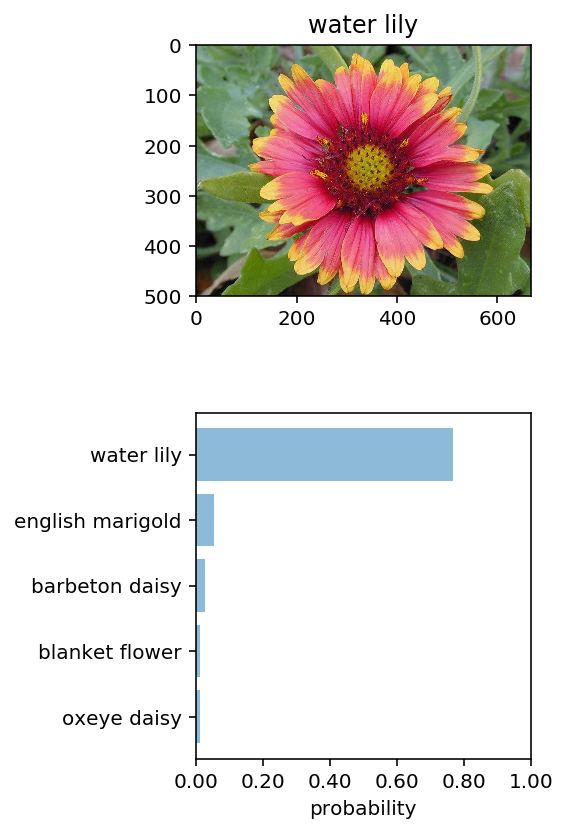